In [96]:
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [97]:
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [98]:
df = pd.read_excel('~/Downloads/sales_sample.xls')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 1.6+ 

In [100]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [101]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [102]:
furniture = df.loc[df['Category'] == 'Furniture']

In [103]:
furniture['Order Date'].max() - furniture['Order Date'].min()

Timedelta('1454 days 00:00:00')

Drop columns we don't need

In [104]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')


/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [105]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [106]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [107]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [108]:
y = furniture['Sales'].resample('MS').mean()

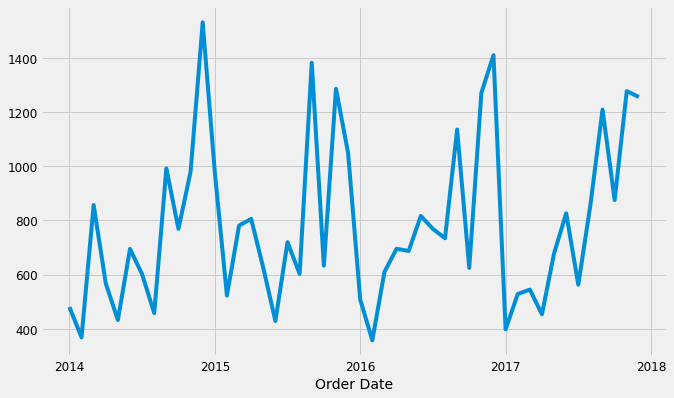

In [109]:
y.plot(figsize=(10, 6))
plt.show()

Decompose time series into different components:
* seasonality
* trend
* noise

In [110]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

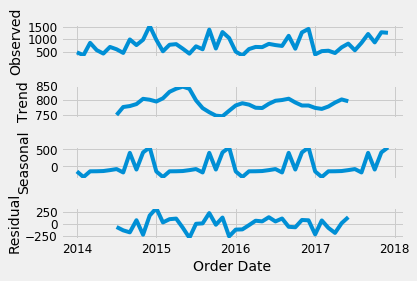

In [111]:
fig = decomposition.plot()
plt.show()

From the plot above:
* The trend is unstable
* Seasonality is strong

### ARIMA forecasting

use the Akaike Information Critera (AIC) to test, which **p, d, q** fit the best

In [112]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA{param}x{param_seasonal} - AIC:{results.aic}')
        except:
            continue

/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1526.6646435881128
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.2314433418337


/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1402.3936867800505
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758108
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2900.5279890044303
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.5607429809134
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.5374579381947
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.9884876946868
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1420.8968510776567
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.78896630044073


/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1283.8048690707233
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.9056176817032
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2609.4821326084448
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.87055484829114
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.18329774427076
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:2491.752385470033
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.7574368417343
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1378.081510905506
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.9259367935198


/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:3.7955078917534805e+85
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.4664675084574
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.7794442185904
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:3132.313062242019
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.3685195815103
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.5763323876715
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:2763.15984565311
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.01560021252703
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:906.6828670723393
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.20034222811347


/home/yurii/Work/study/ml_sandbox/ts/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.34036587846964
ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1271.8531335621694
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.62709013454474
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.031801983523
ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:nan
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.476268760972
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660795
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:2625.787905112484
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.7875439538256


In [113]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -144.894
Date:                            Fri, 03 May 2019   AIC                            297.788
Time:                                    13:09:48   BIC                            302.152
Sample:                                01-01-2014   HQIC                           298.816
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04
===================================================================================
Ljung-Box (Q):                       21.51   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.43   Prob(JB):                         0.66
Heteroskedasticity (H):               0.55   Skew:                             0.44
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+25. Standard errors may be unstable.
"""

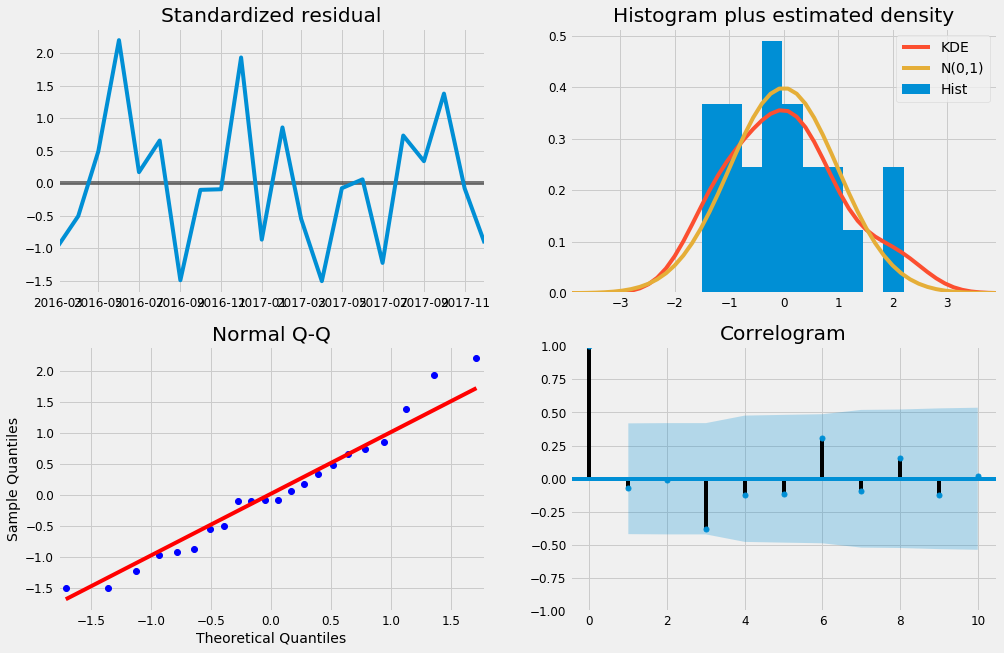

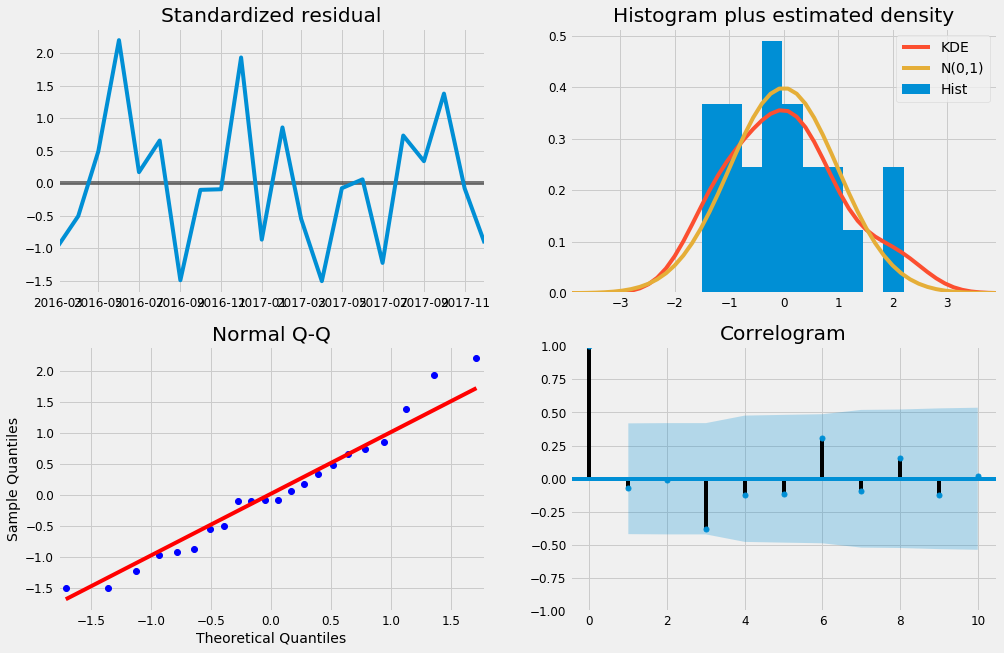

In [114]:
results.plot_diagnostics(figsize=(15, 10))

In [115]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

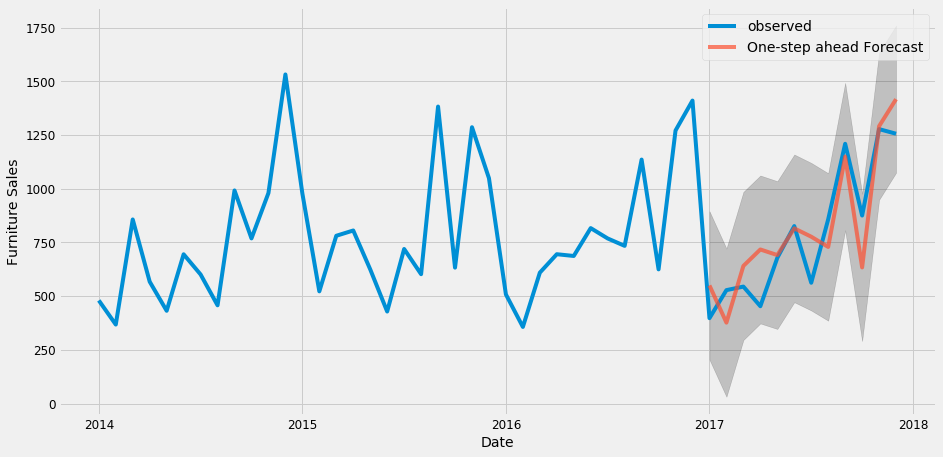

In [116]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [117]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
f'RMSE: {np.sqrt(mse):.3f}'

'RMSE: 151.636'